In [94]:
import os
import pandas as pd
import datetime
import matplotlib.pyplot as plt


In [95]:

path = "./market_data/"

# Filtrar solo los archivos que terminan en .csv
csv_files = [f for f in os.listdir(path) if f.endswith(".csv")]

# Leer cada CSV en un DataFrame y guardarlo en un diccionario
dfs = {fname.replace(".csv", ""): pd.read_csv(os.path.join(path, fname)) for fname in csv_files}


In [96]:
dfs.keys()

dict_keys(['AL30_1205_CI_PESOS', 'dlr_may_1205', 'PESOS-1305', 'AL30_1205_CI_CCL', 'AL30_1205_CI_MEP'])

In [97]:
df_al30ci = dfs['AL30_1205_CI_PESOS']
df_al30ci["fecha"] = df_al30ci["fecha_nano"].apply(lambda x: datetime.datetime.utcfromtimestamp(x*1e-9))


/tmp/ipykernel_19150/3485365850.py:2: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  df_al30ci["fecha"] = df_al30ci["fecha_nano"].apply(lambda x: datetime.datetime.utcfromtimestamp(x*1e-9))


In [98]:
df_al30ci["side"].value_counts()

side
OF       1309080
BI        940321
TRADE     153901
Name: count, dtype: int64

In [113]:
import numpy as np
import pandas as pd

def build_df_for_side(df, curr_side):
    # Filtrar por side
    df_side = df[df["side"] == curr_side]
    if df_side.empty:
        return pd.DataFrame(columns=["fecha_nano", "prices", "quantities", "side"])

    # Arrays
    f = df_side["fecha_nano"].to_numpy(dtype=np.int64)
    p = df_side["price"].to_numpy(dtype=np.int32)
    q = df_side["quantity"].to_numpy(dtype=np.int32)

    # Orden estable por fecha
    order = np.argsort(f, kind="mergesort")
    f_s, p_s, q_s = f[order], p[order], q[order]

    # Agrupar por timestamp
    keys, idx, cnt = np.unique(f_s, return_index=True, return_counts=True)
    starts, ends = idx, idx + cnt

    # Construir filas
    rows = []
    for s, e, k in zip(starts, ends, keys):
        seg_p = p_s[s:e]
        seg_q = q_s[s:e]
        rows.append({
            "fecha_nano": int(k),
            "prices": seg_p[seg_p > 0].tolist(),
            "quantities": seg_q[seg_q > 0].tolist(),
            "side": curr_side
        })

    return pd.DataFrame(rows)

# Descubrir los sides presentes (p. ej. ["BI", "OF", "TRADE"])
sides_presentes = df_al30ci["side"].dropna().unique().tolist()

# Construir un dict con un DF por side
dfs_por_side = {}
for curr_side in sides_presentes:
    dfs_por_side[curr_side] = build_df_for_side(df_al30ci, curr_side)

# Concat final (mismo esquema que antes + columna 'side')
df_concat = pd.concat(dfs_por_side.values(), ignore_index=True)



In [115]:
dfs_por_side["OF"]

,fecha_nano,prices,quantities,side
0,1747058117512618279,[81900],[3000],OF
1,1747058210293570287,"[79440, 81900]","[133223, 3000]",OF
2,1747058214463031494,"[79440, 81000]","[133223, 663]",OF
3,1747058226743689670,"[79440, 81000]","[143223, 663]",OF
4,1747058290708782688,"[79440, 80400, 81000]","[143223, 266620, 663]",OF
...,...,...,...,...
265763,1747078219158102591,"[77720, 77780, 77800]","[11808, 2647, 556]",OF
265764,1747078219158320313,"[77720, 77780, 77800, 77840]","[11808, 2647, 556, 148]",OF
265765,1747078219158557609,"[77720, 77780, 77800, 77840, 77950]","[11808, 2647, 556, 148, 200000]",OF
265766,1747078426428358492,"[77720, 77780, 77800, 77840]","[11808, 2647, 556, 148]",OF


In [116]:
import pandas as pd
import numpy as np

def build_metrics(df):
    def _row_metrics(row):
        prices = np.asarray(row["prices"], dtype=float)
        qtys = np.asarray(row["quantities"], dtype=float)
        if qtys.size == 0 or np.nansum(qtys) == 0:
            return pd.Series({"vwap": np.nan, "spread": np.nan})
        vwap = np.average(prices, weights=qtys)
        var = np.average((prices - vwap) ** 2, weights=qtys)
        return pd.Series({"vwap": vwap, "spread": np.sqrt(var)})

    metrics = df.apply(_row_metrics, axis=1)
    return pd.concat([df[["fecha_nano", "side"]].reset_index(drop=True), metrics], axis=1)

df_metrics = build_metrics(df_concat)



In [117]:
df_metrics

,fecha_nano,side,vwap,spread
0,1747058117512618279,OF,81900.000000,0.000000
1,1747058210293570287,OF,79494.175873,361.023023
2,1747058214463031494,OF,79447.725080,109.505467
3,1747058226743689670,OF,79447.188191,105.649928
4,1747058290708782688,OF,80066.030996,458.897225
...,...,...,...,...
611728,1747078010499753898,TRADE,77720.000000,0.000000
611729,1747078016425763650,TRADE,77720.000000,0.000000
611730,1747078016459180789,TRADE,77720.000000,0.000000
611731,1747078019463413165,TRADE,77720.000000,0.000000


In [128]:
import pandas as pd

df_metrics = df_metrics.sort_values("fecha_nano").reset_index(drop=True)

def add_time_deltas(df, col="fecha_nano"):
    df = df.copy()
    delta_ns = df[col].diff()  # diferencia entre filas consecutivas

    df["delta_ns"] = delta_ns
    df["delta_us"] = delta_ns / 1e3   # microsegundos
    df["delta_ms"] = delta_ns / 1e6   # milisegundos
    df["delta_s"]  = delta_ns / 1e9   # segundos

    # tiempo relativo desde el primer timestamp
    first_ts = df[col].iloc[0]
    df["t_rel_ms"] = (df[col] - first_ts) / 1e6

    return df

df_metrics = add_time_deltas(df_metrics)
df_metrics = df_metrics[df_metrics["t_rel_ms"] > 4e5]


## Elegimos una ventana

In [ ]:
i, j = df_metrics[ini], df_metrics[fin]
df_metrics = df_metrics[i,j,:]

610044

Side=TRADE: 10 puntos en ventana [1000000.000, 1100000.000] ms
Side=BI: 17 puntos en ventana [1000000.000, 1100000.000] ms
Side=OF: 21 puntos en ventana [1000000.000, 1100000.000] ms


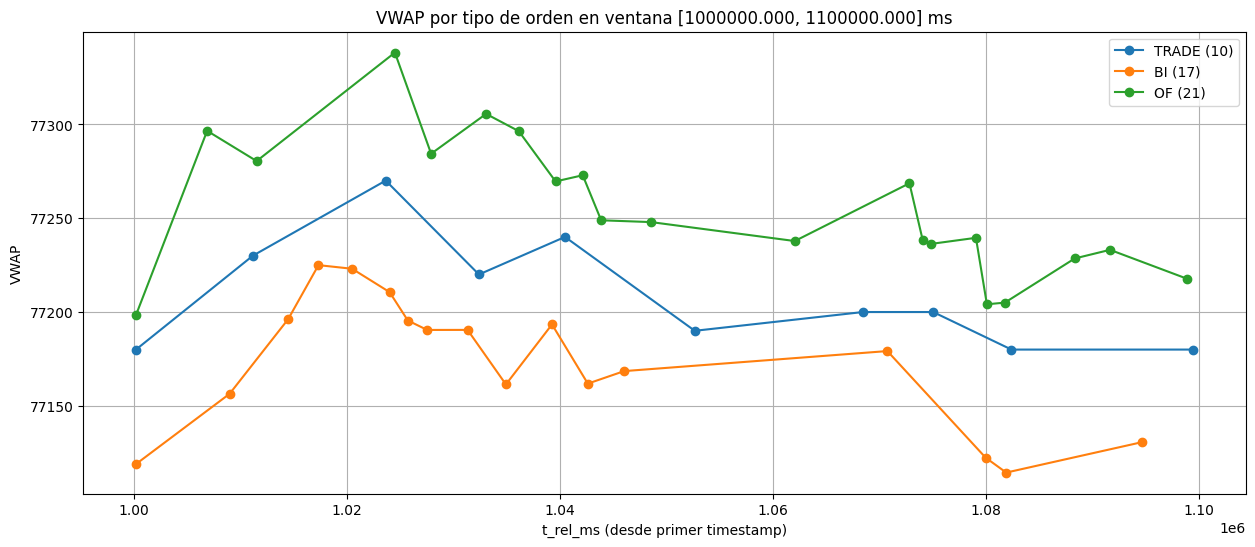

In [146]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def select_time_window_by_time(df, t_start_ms=None, t_end_ms=None, window_ms=None, time_col="t_rel_ms"):
    if len(df) == 0:
        return df.copy(), (np.nan, np.nan)

    df_sorted = df.sort_values(time_col).reset_index(drop=True)
    t_min, t_max = df_sorted[time_col].iloc[0], df_sorted[time_col].iloc[-1]

    if t_start_ms is not None and window_ms is not None:
        t_start, t_end = t_start_ms, t_start_ms + window_ms
    elif t_end_ms is not None and window_ms is not None:
        t_start, t_end = t_end_ms - window_ms, t_end_ms
    elif t_start_ms is not None and t_end_ms is not None:
        t_start, t_end = t_start_ms, t_end_ms
    else:
        raise ValueError("Especificá (t_start_ms y window_ms) o (t_end_ms y window_ms) o (t_start_ms y t_end_ms).")

    if t_start > t_end:
        t_start, t_end = t_end, t_start
    t_start = max(t_min, t_start)
    t_end   = min(t_max, t_end)

    mask = (df[time_col] >= t_start) & (df[time_col] <= t_end)
    return df.loc[mask].copy(), (t_start, t_end)

def plot_vwap_window_time(df_metrics, t_start_ms=None, t_end_ms=None, window_ms=None,
                          sample_step: int = 1, per_side_head_frac: float = 1.0):
    df_win, (t_start, t_end) = select_time_window_by_time(
        df_metrics, t_start_ms=t_start_ms, t_end_ms=t_end_ms, window_ms=window_ms, time_col="t_rel_ms"
    )
    if len(df_win) == 0:
        print("Ventana sin datos.")
        return

    plt.figure(figsize=(15, 6))
    for curr_side in df_win["side"].dropna().unique():
        df_side = df_win[df_win["side"] == curr_side].sort_values("t_rel_ms")
        if sample_step > 1:
            df_side = df_side.iloc[::sample_step, :]
        if 0 < per_side_head_frac < 1:
            n_keep = max(1, int(len(df_side) * per_side_head_frac))
            df_side = df_side.head(n_keep)
        if len(df_side) == 0:
            continue

        # imprimir cantidad de puntos
        print(f"Side={curr_side}: {len(df_side)} puntos en ventana [{t_start:.3f}, {t_end:.3f}] ms")

        # también mostrarlo en la leyenda
        plt.plot(df_side["t_rel_ms"], df_side["vwap"], '-o', label=f"{curr_side} ({len(df_side)})")

    plt.xlabel("t_rel_ms (desde primer timestamp)")
    plt.ylabel("VWAP")
    plt.title(f"VWAP por tipo de orden en ventana [{t_start:.3f}, {t_end:.3f}] ms")
    plt.legend()
    plt.grid(True)
    plt.show()

# Ejemplo de uso
df_metrics = df_metrics.sort_values("t_rel_ms").reset_index(drop=True)
plot_vwap_window_time(df_metrics, t_start_ms=1e6, window_ms=1e5, sample_step=100)


In [132]:
df_metrics

,fecha_nano,side,vwap,spread,delta_ns,delta_us,delta_ms,delta_s,t_rel_ms
0,1747058517840168177,TRADE,77590.000000,0.000000,8.688565e+08,8.688565e+05,868.856492,0.868856,4.003275e+05
1,1747058517847546493,TRADE,77590.000000,0.000000,7.378316e+06,7.378316e+03,7.378316,0.007378,4.003349e+05
2,1747058517870543060,TRADE,77590.000000,0.000000,2.299657e+07,2.299657e+04,22.996567,0.022997,4.003579e+05
3,1747058517873965247,OF,77641.133572,19.620617,3.422187e+06,3.422187e+03,3.422187,0.003422,4.003613e+05
4,1747058517905895259,BI,77535.817171,14.534895,3.193001e+07,3.193001e+04,31.930012,0.031930,4.003933e+05
...,...,...,...,...,...,...,...,...,...
610039,1747078259405494646,BI,77709.004279,7.577384,4.024694e+10,4.024694e+07,40246.937037,40.246937,2.014189e+07
610040,1747078259405713714,BI,77708.526649,10.440342,2.190680e+05,2.190680e+02,0.219068,0.000219,2.014189e+07
610041,1747078288919089629,BI,77708.526954,10.440404,2.951338e+10,2.951338e+07,29513.375915,29.513376,2.017141e+07
610042,1747078426428358492,OF,77734.582756,28.129843,1.375093e+11,1.375093e+08,137509.268863,137.509269,2.030892e+07


## Ejemplo kalman

RMSE posición - d=2: 1.5720 m | d=3: 1.6521 m
RMSE velocidad - d=2: 0.5806 m/s | d=3: 0.6545 m/s


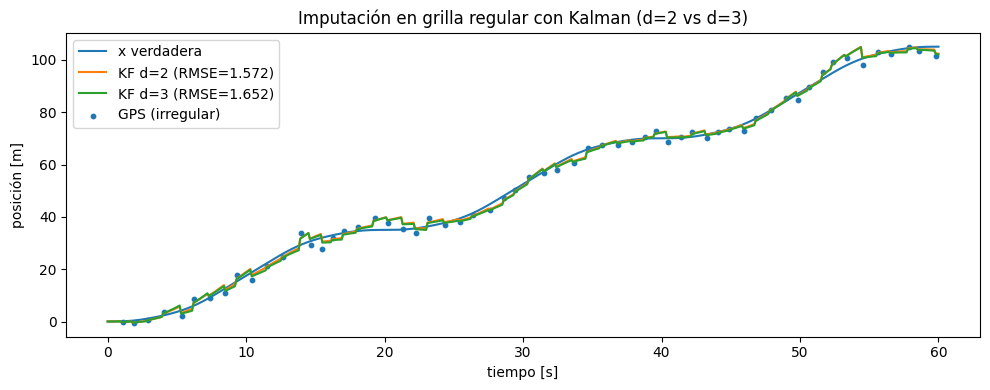

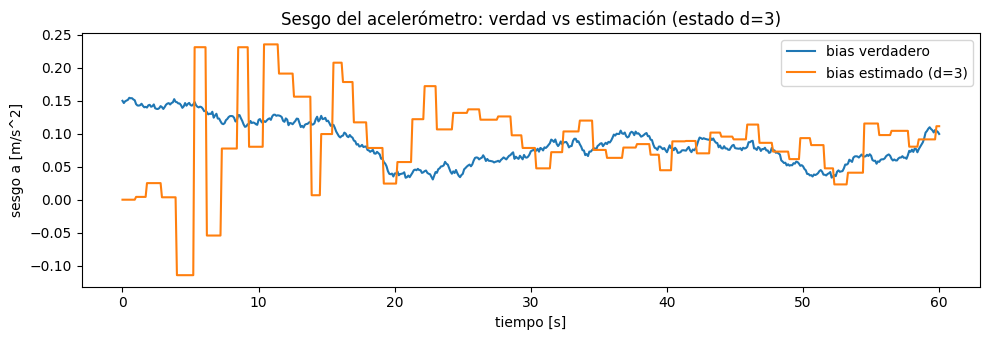

In [141]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Demo: Imputación en grilla regular con modelos de espacio de estados (Kalman)
Escenario físico: auto 1D con GPS irregular (posición) y acelerómetro con sesgo.
Compara:
  - d=2: estado [x, v]
  - d=3: estado [x, v, b] con bias b ~ RW
Genera gráficos y RMSE.
"""
import numpy as np
import matplotlib.pyplot as plt

def simulate_world(T=60.0, dt_true=0.01, seed=42,
                   sigma_a=0.05, sigma_gps=2.0, sigma_b=0.001,
                   gps_interval_min=0.7, gps_interval_max=1.3, b0=0.15):
    rng = np.random.default_rng(seed)
    t_true = np.arange(0, T+dt_true, dt_true)
    # aceleración verdadera (suave)
    a_true = 0.5*np.sin(2*np.pi*0.05*t_true) + 0.2*np.sin(2*np.pi*0.2*t_true)
    # sesgo verdadero (RW)
    b_true = np.zeros_like(t_true); b_true[0] = b0
    for k in range(1, len(t_true)):
        b_true[k] = b_true[k-1] + rng.normal(0, sigma_b)
    # dinámica verdadera
    x_true = np.zeros_like(t_true); v_true = np.zeros_like(t_true)
    for k in range(1, len(t_true)):
        dt = dt_true
        x_true[k] = x_true[k-1] + v_true[k-1]*dt + 0.5*a_true[k-1]*dt*dt
        v_true[k] = v_true[k-1] + a_true[k-1]*dt
    # sensores
    a_meas_truegrid = a_true + b_true + rng.normal(0, sigma_a, size=len(t_true))
    # GPS irregular
    gps_times = []
    t = 0.0
    while t < T:
        t += rng.uniform(gps_interval_min, gps_interval_max)
        if t < T: gps_times.append(t)
    gps_times = np.array(gps_times)
    x_gps_true = np.interp(gps_times, t_true, x_true)
    z_gps = x_gps_true + rng.normal(0, sigma_gps, size=len(gps_times))
    return t_true, x_true, v_true, a_true, b_true, a_meas_truegrid, gps_times, z_gps

def build_grid(t_true, x_true, v_true, b_true, a_meas_truegrid, gps_times, z_gps, dt=0.1):
    t_grid = np.arange(0, t_true[-1] + dt, dt)
    a_meas = np.interp(t_grid, t_true, a_meas_truegrid)
    # mapear GPS a índices de grilla (causal)
    gps_idx = np.searchsorted(t_grid, gps_times, side='left')
    z_gps_grid = np.full_like(t_grid, np.nan, dtype=float)
    for gi, tg_idx in enumerate(gps_idx):
        if tg_idx < len(t_grid):
            if t_grid[tg_idx] > gps_times[gi] and tg_idx > 0:
                tg_idx -= 1
            z_gps_grid[tg_idx] = z_gps[gi]
    # verdad en grilla
    x_true_grid = np.interp(t_grid, t_true, x_true)
    v_true_grid = np.interp(t_grid, t_true, v_true)
    b_true_grid = np.interp(t_grid, t_true, b_true)
    return t_grid, a_meas, z_gps_grid, x_true_grid, v_true_grid, b_true_grid, gps_times

def kf_impute_d2(t_grid, a_meas, z_gps_grid, q_c=0.5, r_gps=4.0, x0=0.0, v0=0.0):
    n = len(t_grid)
    s = np.zeros((n, 2)); P = np.zeros((n, 2, 2))
    s[0] = np.array([x0, v0]); P[0] = np.diag([10.0, 10.0])
    H = np.array([[1.0, 0.0]]); R = np.array([[r_gps]])
    for k in range(1, n):
        dt = t_grid[k] - t_grid[k-1]
        F = np.array([[1.0, dt],[0.0, 1.0]])
        B = np.array([[0.5*dt*dt],[dt]])
        Q = q_c * np.array([[dt**3/3.0, dt**2/2.0],[dt**2/2.0, dt]])
        s_pred = F @ s[k-1] + (B.flatten() * a_meas[k-1])
        P_pred = F @ P[k-1] @ F.T + Q
        if not np.isnan(z_gps_grid[k]):
            y = z_gps_grid[k] - (H @ s_pred)
            S = H @ P_pred @ H.T + R
            K = P_pred @ H.T @ np.linalg.inv(S)
            s[k] = s_pred + (K @ y).flatten()
            P[k] = (np.eye(2) - K @ H) @ P_pred
        else:
            s[k], P[k] = s_pred, P_pred
    return s, P

def kf_impute_d3(t_grid, a_meas, z_gps_grid, q_c=0.5, q_b=1e-3, r_gps=4.0, x0=0.0, v0=0.0, b0=0.0):
    n = len(t_grid)
    s = np.zeros((n, 3)); P = np.zeros((n, 3, 3))
    s[0] = np.array([x0, v0, b0]); P[0] = np.diag([10.0, 10.0, 0.5])
    H = np.array([[1.0, 0.0, 0.0]]); R = np.array([[r_gps]])
    for k in range(1, n):
        dt = t_grid[k] - t_grid[k-1]
        F = np.array([[1.0, dt, -0.5*dt*dt],[0.0, 1.0, -dt],[0.0, 0.0, 1.0]])
        B = np.array([[0.5*dt*dt],[dt],[0.0]])
        Q_cv = q_c * np.array([[dt**3/3.0, dt**2/2.0],[dt**2/2.0, dt]])
        Q = np.zeros((3,3)); Q[0:2,0:2] = Q_cv; Q[2,2] = q_b * dt
        s_pred = F @ s[k-1] + (B.flatten() * a_meas[k-1])
        P_pred = F @ P[k-1] @ F.T + Q
        if not np.isnan(z_gps_grid[k]):
            y = z_gps_grid[k] - (H @ s_pred)
            S = H @ P_pred @ H.T + R
            K = P_pred @ H.T @ np.linalg.inv(S)
            s[k] = s_pred + (K @ y).flatten()
            P[k] = (np.eye(3) - K @ H) @ P_pred
        else:
            s[k], P[k] = s_pred, P_pred
    return s, P

def rmse(a, b): return float(np.sqrt(np.mean((a-b)**2)))

def main():
    # --- Simulación del mundo ---
    t_true, x_true, v_true, a_true, b_true, a_meas_truegrid, gps_times, z_gps = simulate_world()
    # --- Construir grilla regular ---
    t_grid, a_meas, z_gps_grid, x_true_g, v_true_g, b_true_g, gps_times = build_grid(
        t_true, x_true, v_true, b_true, a_meas_truegrid, gps_times, z_gps, dt=0.1
    )
    # --- Filtros ---
    s2, P2 = kf_impute_d2(t_grid, a_meas, z_gps_grid, q_c=0.5, r_gps=2.0**2)
    s3, P3 = kf_impute_d3(t_grid, a_meas, z_gps_grid, q_c=0.5, q_b=1e-3, r_gps=2.0**2)
    x2, v2 = s2[:,0], s2[:,1]
    x3, v3, b3 = s3[:,0], s3[:,1], s3[:,2]
    # --- Métricas ---
    print(f"RMSE posición - d=2: {rmse(x2, x_true_g):.4f} m | d=3: {rmse(x3, x_true_g):.4f} m")
    print(f"RMSE velocidad - d=2: {rmse(v2, v_true_g):.4f} m/s | d=3: {rmse(v3, v_true_g):.4f} m/s")
    # --- Plots ---
    plt.figure(figsize=(10,4))
    plt.plot(t_grid, x_true_g, label="x verdadera")
    plt.plot(t_grid, x2, label=f"KF d=2 (RMSE={rmse(x2, x_true_g):.3f})")
    plt.plot(t_grid, x3, label=f"KF d=3 (RMSE={rmse(x3, x_true_g):.3f})")
    plt.scatter(gps_times, z_gps, s=10, label="GPS (irregular)")
    plt.xlabel("tiempo [s]"); plt.ylabel("posición [m]")
    plt.title("Imputación en grilla regular con Kalman (d=2 vs d=3)")
    plt.legend(); plt.tight_layout(); plt.show()

    plt.figure(figsize=(10,3.5))
    plt.plot(t_grid, b_true_g, label="bias verdadero")
    plt.plot(t_grid, b3, label="bias estimado (d=3)")
    plt.xlabel("tiempo [s]"); plt.ylabel("sesgo a [m/s^2]")
    plt.title("Sesgo del acelerómetro: verdad vs estimación (estado d=3)")
    plt.legend(); plt.tight_layout(); plt.show()

if __name__ == "__main__":
    main()


## Var Sintetico

RMSE 1-step en validación por variable: [0.9036 0.924  0.6959]


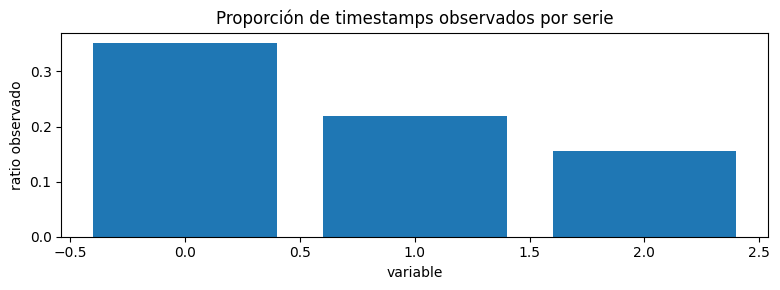

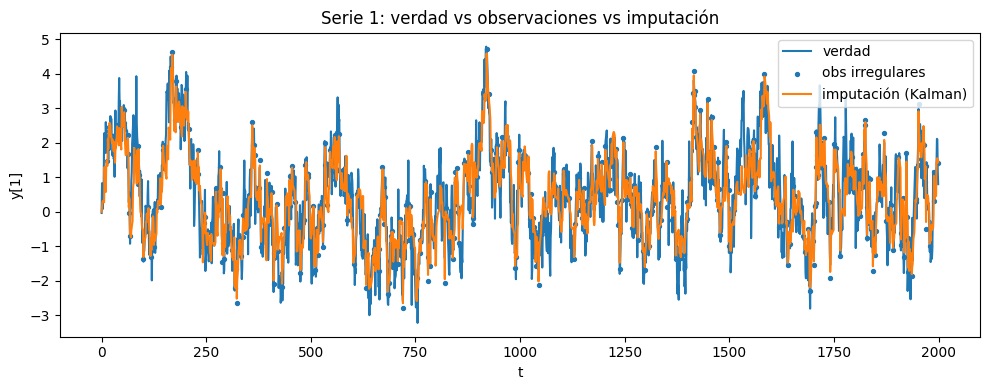

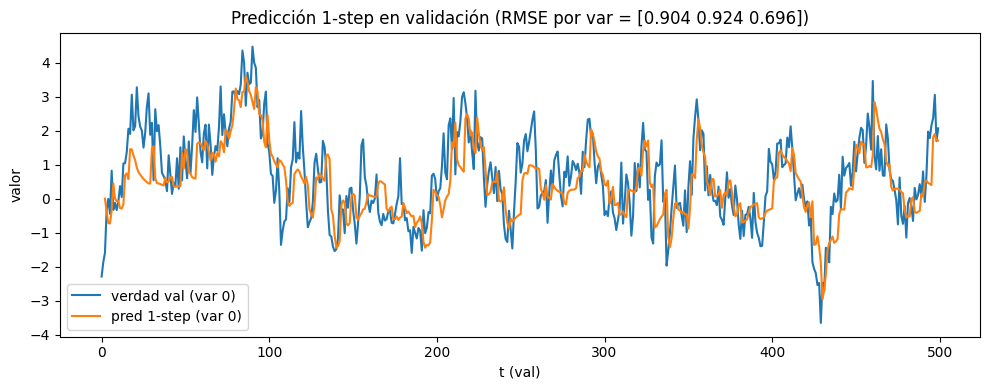

In [148]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Demo completo:
  1) Simula un VAR(2) de 3 variables (datos verdaderos "limpios").
  2) Genera observaciones irregulares y ruidosas por variable.
  3) Imputa a grilla regular con Kalman (estado [y_t; y_{t-1}]).
  4) Ajusta VAR(2) por OLS a la serie imputada.
  5) Evalúa RMSE 1-step-ahead en validación.
Solo usa numpy y matplotlib.
"""
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import inv, lstsq

def simulate_var2(T=2000, seed=7):
    rng = np.random.default_rng(seed)
    d = 3
    A1 = np.array([[ 0.6,  0.1,  0.0],
                   [ 0.2,  0.5,  0.1],
                   [ 0.0,  0.2,  0.4]])
    A2 = np.array([[ 0.2,  0.0,  0.0],
                   [ 0.0,  0.2,  0.0],
                   [ 0.0,  0.0,  0.2]])
    Sigma_e = np.array([[0.5, 0.1, 0.0],
                        [0.1, 0.4, 0.1],
                        [0.0, 0.1, 0.3]])
    y = np.zeros((T, d))
    y[0] = rng.multivariate_normal(np.zeros(d), Sigma_e)
    y[1] = rng.multivariate_normal(np.zeros(d), Sigma_e)
    for t in range(2, T):
        e_t = rng.multivariate_normal(np.zeros(d), Sigma_e)
        y[t] = A1 @ y[t-1] + A2 @ y[t-2] + e_t
    return y, A1, A2, Sigma_e

def make_irregular_observations(y, obs_prob=(0.35, 0.22, 0.15), sigma_meas=(0.2, 0.25, 0.3), seed=7):
    rng = np.random.default_rng(seed)
    T, d = y.shape
    M = rng.uniform(size=(T, d)) < np.array(obs_prob)
    z = np.full_like(y, np.nan, dtype=float)
    for j in range(d):
        noise = rng.normal(0, sigma_meas[j], size=T)
        z[M[:, j], j] = y[M[:, j], j] + noise[M[:, j]]
    return z, M, np.array(sigma_meas)**2

def kalman_impute_var2(z, M, A1, A2, Sigma_e, R_diag):
    T, d = z.shape
    k = 2*d
    F = np.block([[A1, A2],[np.eye(d), np.zeros((d,d))]])
    Q = np.block([[Sigma_e, np.zeros((d,d))],[np.zeros((d,d)), np.zeros((d,d))]])
    s = np.zeros(k); P = np.eye(k)*5.0
    y_hat = np.zeros((T, d))
    for t in range(T):
        s_pred = F @ s
        P_pred = F @ P @ F.T + Q
        obs_idx = np.where(M[t])[0]
        if obs_idx.size > 0:
            H = np.zeros((len(obs_idx), k))
            for i, j in enumerate(obs_idx): H[i, j] = 1.0
            R = np.diag(R_diag[obs_idx])
            z_t = z[t, obs_idx]
            y_innov = z_t - H @ s_pred
            S = H @ P_pred @ H.T + R
            K = P_pred @ H.T @ np.linalg.inv(S)
            s = s_pred + K @ y_innov
            P = (np.eye(k) - K @ H) @ P_pred
        else:
            s, P = s_pred, P_pred
        y_hat[t] = s[:d]
    return y_hat

def fit_var_ols(y, p=2):
    T, d = y.shape
    X, Y = [], []
    for t in range(p, T):
        X.append(np.hstack([y[t-1], y[t-2]]))
        Y.append(y[t])
    X = np.array(X); Y = np.array(Y)
    Beta, _, _, _ = lstsq(X, Y, rcond=None)  # [2d, d]
    A1_hat = Beta[:d].T; A2_hat = Beta[d:].T
    return A1_hat, A2_hat

def one_step_rmse(y_true, y_feat, A1_hat, A2_hat, start_idx=2):
    T, d = y_true.shape
    preds, reals = [], []
    for t in range(start_idx, T):
        preds.append(A1_hat @ y_feat[t-1] + A2_hat @ y_feat[t-2])
        reals.append(y_true[t])
    preds = np.array(preds); reals = np.array(reals)
    return np.sqrt(np.mean((preds - reals)**2, axis=0)), preds, reals

def main():
    y, A1, A2, Sigma_e = simulate_var2(T=2000, seed=7)
    T_train = 1500
    y_train, y_val = y[:T_train], y[T_train:]
    z, M, R_diag = make_irregular_observations(y, seed=7)
    z_train, z_val = z[:T_train], z[T_train:]
    M_train, M_val = M[:T_train], M[T_train:]
    yhat_train = kalman_impute_var2(z_train, M_train, A1, A2, Sigma_e, R_diag)
    yhat_val   = kalman_impute_var2(z_val,   M_val,   A1, A2, Sigma_e, R_diag)
    yhat_all = np.vstack([yhat_train, yhat_val])
    A1_hat, A2_hat = fit_var_ols(yhat_train, p=2)
    rmse_val, preds, reals = one_step_rmse(y_true=y_val, y_feat=yhat_all[len(y_train):], A1_hat=A1_hat, A2_hat=A2_hat, start_idx=2)
    print("RMSE 1-step en validación por variable:", np.round(rmse_val, 4))

    # Gráficos
    import matplotlib.pyplot as plt
    obs_ratio = M.mean(axis=0)
    plt.figure(figsize=(8,3))
    plt.bar(range(y.shape[1]), obs_ratio)
    plt.xlabel("variable"); plt.ylabel("ratio observado")
    plt.title("Proporción de timestamps observados por serie")
    plt.tight_layout(); plt.show()

    j = 1
    plt.figure(figsize=(10,4))
    plt.plot(y[:, j], label="verdad")
    idx_obs = np.where(~np.isnan(z[:, j]))[0]
    plt.scatter(idx_obs, z[idx_obs, j], s=8, label="obs irregulares")
    plt.plot(yhat_all[:, j], label="imputación (Kalman)")
    plt.xlabel("t"); plt.ylabel(f"y[{j}]")
    plt.title(f"Serie {j}: verdad vs observaciones vs imputación")
    plt.legend(); plt.tight_layout(); plt.show()

    plt.figure(figsize=(10,4))
    t_val = np.arange(len(y_val))
    plt.plot(t_val, y_val[:, 0], label="verdad val (var 0)")
    plt.plot(t_val[2:], preds[:, 0], label="pred 1-step (var 0)")
    plt.xlabel("t (val)"); plt.ylabel("valor")
    plt.title(f"Predicción 1-step en validación (RMSE por var = {np.round(rmse_val,3)})")
    plt.legend(); plt.tight_layout(); plt.show()

if __name__ == "__main__":
    main()
